# Data Preprocessing for FraudDiffuse Implementation

This notebook implements the data preprocessing steps as specified in the FraudDiffuse paper. We will:
1. Load and combine the datasets
2. Handle missing values
3. Encode categorical features
4. Transform numerical features
5. Split the data into train/validation/test sets

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [49]:
# Load datasets
print("Loading datasets...")
train_df = pd.read_csv('Data/Sparkov/fraudTrain.csv')
test_df = pd.read_csv('Data/Sparkov/fraudTest.csv')

# Combine datasets
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

print("\nDataset Overview:")
print(f"Total samples: {len(df)}")
print(f"Fraud samples: {len(df[df['is_fraud'] == 1])}")
print(f"Fraud rate: {len(df[df['is_fraud'] == 1]) / len(df) * 100:.2f}%")

# Display initial data info
print("\nDataset Info:")
df.info()

Loading datasets...

Dataset Overview:
Total samples: 1852394
Fraud samples: 9651
Fraud rate: 0.52%

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Unnamed: 0             int64  
 1   trans_date_trans_time  object 
 2   cc_num                 int64  
 3   merchant               object 
 4   category               object 
 5   amt                    float64
 6   first                  object 
 7   last                   object 
 8   gender                 object 
 9   street                 object 
 10  city                   object 
 11  state                  object 
 12  zip                    int64  
 13  lat                    float64
 14  long                   float64
 15  city_pop               int64  
 16  job                    object 
 17  dob                    object 
 18  trans_num              object 
 19  unix_time  

In [50]:
# Calculate missing value percentages
missing_pct = df.isnull().sum() / len(df) * 100

# Check if there are any missing values
if missing_pct[missing_pct > 0].empty:
    print("No missing values found in the dataset!")
else:
    # Plot missing value percentages
    plt.figure(figsize=(15, 5))
    missing_pct[missing_pct > 0].sort_values(ascending=False).plot(kind='bar')
    plt.title('Missing Values Percentage by Feature')
    plt.xlabel('Features')
    plt.ylabel('Missing Percentage')
    plt.xticks(rotation=45)
    plt.axhline(y=20, color='r', linestyle='--', label='20% threshold')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Drop features with more than 20% missing values
    cols_to_drop = missing_pct[missing_pct > 20].index
    df = df.drop(columns=cols_to_drop)
    print(f"Dropped {len(cols_to_drop)} columns with >20% missing values")

    # Fill missing values
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object']).columns

    for col in num_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())

    for col in cat_cols:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].mode()[0])

print("\nVerifying missing values:")
print(f"Total missing values: {df.isnull().sum().sum()}")

No missing values found in the dataset!

Verifying missing values:
Total missing values: 0


In [51]:
categorical_columns = df.select_dtypes(include=['object']).columns
encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

print(f"Encoded {len(categorical_columns)} categorical features:")
print(list(categorical_columns))

Encoded 12 categorical features:
['trans_date_trans_time', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num']


Original Raw Amount statistics:
count    1.852394e+06
mean     7.006357e+01
std      1.592540e+02
min      1.000000e+00
25%      9.640000e+00
50%      4.745000e+01
75%      8.310000e+01
max      2.894890e+04
Name: amt, dtype: float64


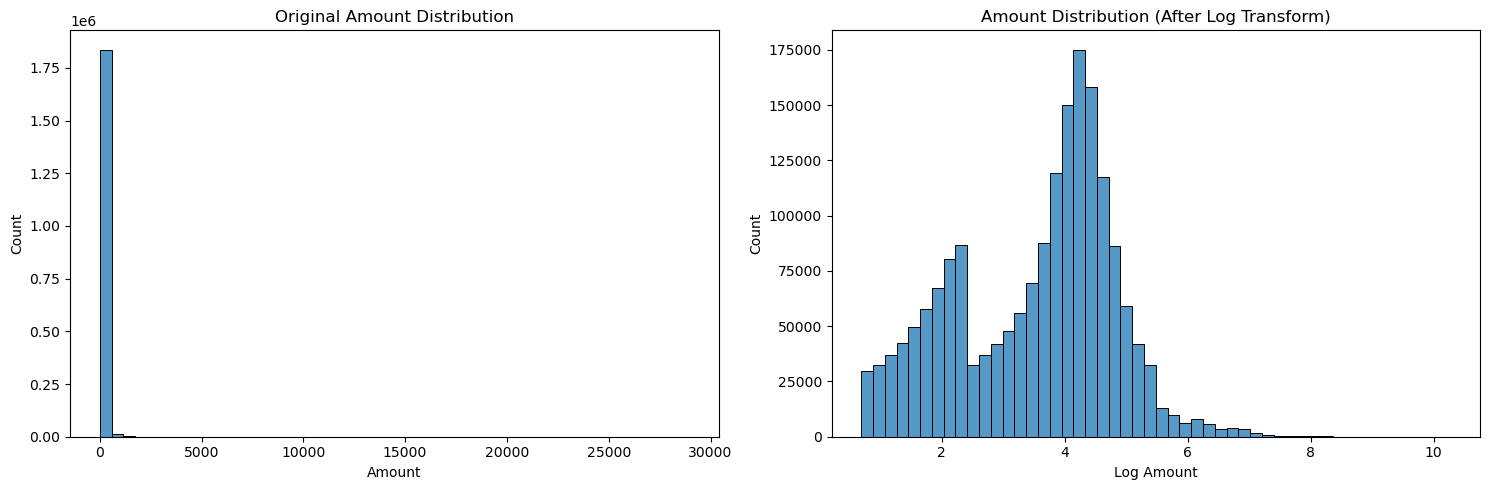


Amount statistics after log transform:
count    1.852394e+06
mean     3.531722e+00
std      1.288350e+00
min      6.931472e-01
25%      2.364620e+00
50%      3.880532e+00
75%      4.432007e+00
max      1.027332e+01
Name: amt, dtype: float64

Amount statistics after standardization:
count    1.852394e+06
mean     2.450007e-16
std      1.000000e+00
min     -2.203265e+00
25%     -9.058887e-01
50%      2.707423e-01
75%      6.987894e-01
max      5.232742e+00
Name: amt, dtype: float64


In [52]:
# Reload the data to start fresh
train_df = pd.read_csv('Data/Sparkov/fraudTrain.csv')
test_df = pd.read_csv('Data/Sparkov/fraudTest.csv')
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# First, let's look at the original raw amount distribution
print("Original Raw Amount statistics:")
print(df['amt'].describe())

# Plot distributions
plt.figure(figsize=(15, 5))

# First subplot - original raw data
plt.subplot(121)
sns.histplot(data=df, x='amt', bins=50, stat='count')
plt.title('Original Amount Distribution')
plt.xlabel('Amount')
plt.ylabel('Count')

# Apply log transform to raw amounts
df['amt'] = np.log1p(df['amt'])

# Second subplot - after log transform
plt.subplot(122)
sns.histplot(data=df, x='amt', bins=50, stat='count')
plt.title('Amount Distribution (After Log Transform)')
plt.xlabel('Log Amount')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

print("\nAmount statistics after log transform:")
print(df['amt'].describe())

# Now apply standardization to all numerical features
scaler = StandardScaler()
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

print("\nAmount statistics after standardization:")
print(df['amt'].describe())

In [ ]:
# Let's start fresh by reloading the data
train_df = pd.read_csv('Data/Sparkov/fraudTrain.csv')
test_df = pd.read_csv('Data/Sparkov/fraudTest.csv')
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# Store fraud labels separately to prevent them from being transformed
fraud_labels = df['is_fraud'].copy()

# Now let's process in the correct order:

# 1. First handle datetime features
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['trans_hour'] = df['trans_date_trans_time'].dt.hour
df['trans_day'] = df['trans_date_trans_time'].dt.day
df['trans_month'] = df['trans_date_trans_time'].dt.month
df['trans_dayofweek'] = df['trans_date_trans_time'].dt.dayofweek
df.drop('trans_date_trans_time', axis=1, inplace=True)

# 2. Handle categorical features
categorical_columns = df.select_dtypes(include=['object']).columns
encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

# 3. Split the data
train_val, test = train_test_split(df, test_size=0.2, stratify=fraud_labels, random_state=42)
train_val_fraud = fraud_labels[train_val.index]
test_fraud = fraud_labels[test.index]

train, val = train_test_split(train_val, test_size=0.1875, stratify=train_val_fraud, random_state=42)
train_fraud = train_val_fraud[train.index]
val_fraud = train_val_fraud[val.index]

# 4. Transform amount and standardize numerical features
# First log transform
train['amt'] = np.log1p(train['amt'])
val['amt'] = np.log1p(val['amt'])
test['amt'] = np.log1p(test['amt'])

# Then standardize - fit only on training data
scaler = StandardScaler()
numerical_columns = train.select_dtypes(include=['int64', 'float64']).columns
numerical_columns = numerical_columns.drop('is_fraud')  # Remove fraud label from standardization

# Fit on training data only
scaler.fit(train[numerical_columns])

# Transform all sets
train[numerical_columns] = scaler.transform(train[numerical_columns])
val[numerical_columns] = scaler.transform(val[numerical_columns])
test[numerical_columns] = scaler.transform(test[numerical_columns])

# Restore fraud labels
train['is_fraud'] = train_fraud
val['is_fraud'] = val_fraud
test['is_fraud'] = test_fraud

# Save the encoders and scaler for later use
import joblib
joblib.dump(encoders, 'Data/processed/label_encoders.pkl')
joblib.dump(scaler, 'Data/processed/standard_scaler.pkl')

# Save processed datasets
train.to_csv('Data/processed/train.csv', index=False)
val.to_csv('Data/processed/val.csv', index=False)
test.to_csv('Data/processed/test.csv', index=False)

# Print information about the splits
print("\nDataset splits information:")
print(f"Training set size: {len(train)} ({len(train)/len(df)*100:.1f}%)")
print(f"Validation set size: {len(val)} ({len(val)/len(df)*100:.1f}%)")
print(f"Test set size: {len(test)} ({len(test)/len(df)*100:.1f}%)")

print("\nFraud distribution:")
print("Training set fraud rate: {:.2f}%".format(train['is_fraud'].mean() * 100))
print("Validation set fraud rate: {:.2f}%".format(val['is_fraud'].mean() * 100))
print("Test set fraud rate: {:.2f}%".format(test['is_fraud'].mean() * 100))

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [37]:
train_df = pd.read_csv('Data/processed/train.csv')
y = train_df['is_fraud']

In [38]:
identifier_columns = ['cc_num', 'first', 'last', 'trans_num']
columns_to_drop = [col for col in identifier_columns if col in train_df.columns]

In [39]:
if columns_to_drop:
    X = train_df.drop(columns=columns_to_drop + ['is_fraud'], errors='ignore')
else:
    X = train_df.drop('is_fraud', axis=1)

In [40]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
clf.fit(X, y)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [41]:
importances = clf.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df.sort_values(by='Importance', ascending=False, inplace=True)

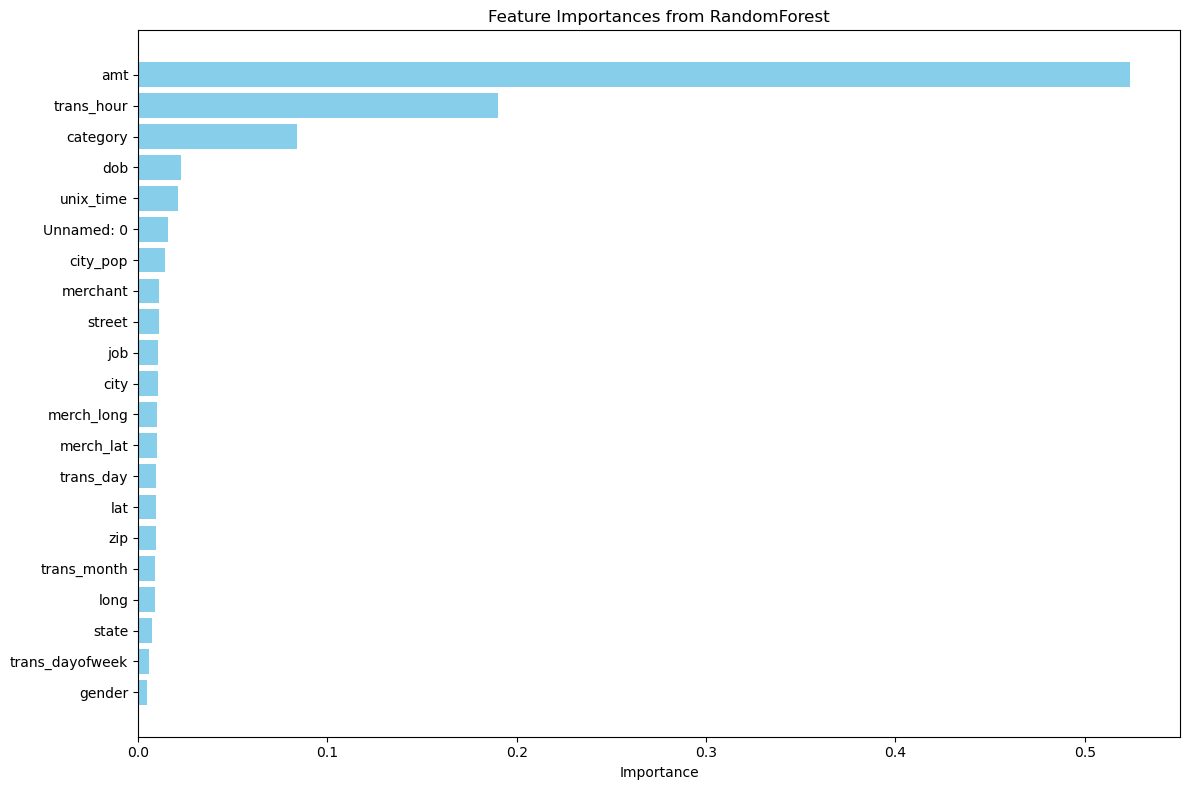

In [ ]:
plt.figure(figsize=(12, 8))
plt.barh(feat_imp_df['Feature'], feat_imp_df['Importance'], color='skyblue')
plt.title('Feature Importances from RandomForest')
plt.xlabel('Importance')
plt.gca().invert_yaxis() # highest importance at the top
plt.tight_layout()
plt.show()

In [43]:
print(feat_imp_df)

            Feature  Importance
3               amt    0.524055
17       trans_hour    0.190147
2          category    0.083928
13              dob    0.022925
14        unix_time    0.021257
0        Unnamed: 0    0.015919
11         city_pop    0.014114
1          merchant    0.011160
5            street    0.010912
12              job    0.010727
6              city    0.010459
16       merch_long    0.010280
15        merch_lat    0.010212
18        trans_day    0.009588
9               lat    0.009364
8               zip    0.009283
19      trans_month    0.009111
10             long    0.008961
7             state    0.007193
20  trans_dayofweek    0.005676
4            gender    0.004729


Clearly the preprocessing has issues so starting over with the data with a clear idea.

In [47]:
import pandas as pd

# Load the train and test CSV files
train_df = pd.read_csv('Data/Sparkov/fraudTrain.csv')
test_df  = pd.read_csv('Data/Sparkov/fraudTest.csv')

# Combine the two datasets
df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# Display basic information about the combined dataframe
print("Combined DataFrame shape:", df.shape)
print(df.head())

Combined DataFrame shape: (1852394, 23)
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      